In [ ]:
!pip install pyts
!pip install --upgrade pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
#from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import sys
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from scipy.fft import fft, dct
import pywt
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def generate_random_vectors(n, r):
    random_vectors = np.random.normal(0, 1, size=(r, n))
    return random_vectors

def MINE(data,R,R_inv):

  prod = np.matmul(data,R)
  bitmap = np.where(prod < 0, 0, 1)
  recon = np.matmul(bitmap,R_inv)
  return recon


def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Number of windows')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig

def plot_score_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

    y_axis_limits = (-1.5, 1.5)  # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)

        # Identify and count outliers based on the limits
        outliers = np.where((y < -1.5) | (y > 1.5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))
        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'Silhouette scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}] ')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
        ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

def plot_ARI_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method
    y_axis_limits = (-1.5, 1.5) # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)
        # Identify and count outliers based on the limits
        outliers = np.where((y < -1.5) | (y > 1.5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))

        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'ARI scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}]')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
        ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig


np.set_printoptions(threshold=sys.maxsize)

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_0_indices = np.where(y == 0)[0]
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_0_indices, label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
data = X[indices]
data = data.T

# Data scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Params
n_features = scaled_data.shape[1]
strides = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA','MINE']
all_labels = []  # create an empty list to store labels for all strides-ARI

#file for storing
folder_name = f"DBSCAN new PUMP Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))

pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
 for stride in strides:

     #set appropriate eps based on elbow crit.
     if stride == 16 : eps = 0.15
     elif stride == 32 : eps = 0.26
     elif stride == 64 : eps = 0.3
     elif stride == 128 : eps = 1

     silhouette_scores = []
     bad_clusters = 0  # count subsets with zero clusters
     all_zero_clusters = 0
     subset_num = 0  #to accurately store labels for ARI

     for i in range(0, n_features-stride, stride):

      subset_length = min(stride, n_features-i)
      subset_data = scaled_data[:, i:i+subset_length]
      clustering = DBSCAN(eps=eps, min_samples=5).fit(subset_data)

      # cluster results
      labels = clustering.labels_
      all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
      n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
      if len(set(labels)) > 1:
        score = silhouette_score(subset_data , clustering.labels_)
        silhouette_scores.append(score)
      else:
        bad_clusters += 1
      # Count number of zero clusters
      if  np.all(labels == 0):
             all_zero_clusters += 1
             silhouette_scores.append(0)
      subset_num = subset_num + 1

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     # check an exo toulaxiston ena score - avoid errors
     if silhouette_scores:
       avg_silhouette = np.mean(silhouette_scores)
     else:
       avg_silhouette = None
     # create a file name based on the method, subset index, stride, and compression
     avg_silhouette = np.mean(silhouette_scores)
     file_name = f"RAW DATA_stride({stride}).txt"
     # write the silhouette coefficients to file
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
      f.write(f"Number of subsets where clustering was not possible: {bad_clusters}\n")
      f.write(f"Number of clusters filled with only zeros: {all_zero_clusters}\n")
      f.write(f"Average Silhouette Score: {avg_silhouette}\n")
      content = str(silhouette_scores)
      f.write(content)
      f.close()

for stride in strides:
    #set appropriate eps based on elbow crit.
    if stride == 16 : eps = 0.15
    elif stride == 32 : eps = 0.26
    elif stride == 64 : eps = 0.3
    elif stride == 128 : eps = 0.4

    #file for storing
    stride_folder_name = f"stride({stride}),eps = {eps})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #vector and inverse vector arrays for our algorithm
        n = 64*int(stride/compression)  # Dimension of each random vector
        r = stride  # Number of random vectors to generate/rows
        R = generate_random_vectors(n, r)
        R_inv= np.linalg.pinv(R)

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
         results1 = []
         results2 = []
         for method in methods:

            slices = stride // compression
            silhouette_scores = []
            ARI_scores = []
            bad_clusters = 0  # count subsets with zero clusters
            all_zero_clusters = 0
            num_subset = 0

            # Iterate over subsets
            for i in range(0, n_features-stride, stride):
              subset_length = min(stride, n_features-i)
              subset_data = scaled_data[:, i:i+subset_length]

              #vector and inverse vector arrays for our algorithm
              # n = 64*int(stride/compression)  # Dimension of each random vector
              # r = stride  # Number of random vectors to generate/rows
              # R = generate_random_vectors(n, r)
              # R_inv= np.linalg.pinv(R)

              if method == 'DFT':

                       #array to store the restored data
                       compressed_subset_data = np.zeros_like(subset_data)

                       for i in range(51):
                          # Compute abs DFT of each row
                          dft_subset_data =  np.fft.fft(subset_data[i])
                          # Sort the DFT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dft_subset_data))[:slices]
                          sorted_dft_subset_data = dft_subset_data[sorted_indices]
                          # Keep  top  coeff
                          top__dft_subset_data = sorted_dft_subset_data[:slices]
                          #reconstruct the compressed dataset
                          compressed_subset_data[i] = np.fft.ifft(top__dft_subset_data,stride).real

              elif method == 'DCT':

                      #array to store the restored data
                       compressed_subset_data = np.zeros_like(subset_data)

                       for i in range(51):
                          # Compute abs DCT of each row
                          dct_subset_data = dct(subset_data[i])
                          # Sort the DCT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dct_subset_data))[:slices]
                          sorted_dct_subset_data = dct_subset_data[sorted_indices]
                          # Keep  top  coeff
                          top__dct_subset_data = sorted_dct_subset_data[:slices]
                          compressed_subset_data[i] = idct(top__dct_subset_data, type=2, n=stride).real

              elif method == 'DWT':

                    #array to store the restored data
                      compressed_subset_data = np.zeros_like(subset_data)

                      for i in range(51):
                          # Apply DWT to each row using 'db1' wavelet
                          cA, cD = pywt.dwt(subset_data[i], 'db1')
                          # Sort
                          sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                          sorted_indices = np.argsort(-np.abs(cD))[:slices]
                          sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                          # Perform inverse DWT to restore the row
                          compressed_subset_data[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')


              elif method == 'PAA':

                      # Apply PAA along the rows of the array
                      paa = PAA(window_size = compression)
                      compressed_subset_data = paa.fit_transform(subset_data)

              elif method == 'MINE':

                    #array to store the restored data
                    compressed_subset_data = np.zeros_like(subset_data)

                    for i in range(51):
                      row = subset_data[i]
                      # Apply my algorithm along the rows of the array
                      compressed_subset_data[i] = MINE(row,R,R_inv)

              clustering = DBSCAN(eps=eps, min_samples=5).fit(compressed_subset_data )
              labels = clustering.labels_

              # cluster results
              if len(set(labels)) > 1:
                  score = silhouette_score(compressed_subset_data , clustering.labels_)
                  silhouette_scores.append(score)
              else:
                bad_clusters += 1
              original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]
              ARI = adjusted_rand_score(original_labels, labels)
              ARI_scores.append(ARI)
              num_subset += 1
              # Count number of zero clusters
              if  np.all(labels == 0):
                       all_zero_clusters += 1
                       silhouette_scores.append(0)

            results1.append((silhouette_scores, method))
            results2.append((ARI_scores, method))

            # check an exo toulaxiston ena score - avoid errors
            if silhouette_scores:
             avg_silhouette = np.mean(silhouette_scores)
            else:
             avg_silhouette = None

            # create a file name based on the method, subset index, stride, and compression
            file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
            # write the silhouette coefficients to file
            with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Number of subsets where clustering was not possible: {bad_clusters}\n")
              f.write(f"Number of clusters filled with only zeros: {all_zero_clusters}\n")
              f.write(f"Average Silhouette Score: {avg_silhouette}\n")
              content = str(silhouette_scores)
              f.write(content)
              f.close()

            avg_ARI = np.mean(ARI_scores)
            file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
            # write the silhouette coefficients to file
            with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average ARI Score: {avg_ARI}\n")
              content = str(ARI_scores)
              f.write(content)
              f.close()
         #store plots
         fig = plot_score_confidence_interval(results1,stride,compression) #plot function call
         pdf.savefig(fig)
         plt.close(fig)
         fig = plot_ARI_confidence_interval(results2,stride,compression) #plot function call
         pdf.savefig(fig)
         plt.close(fig)




<ipython-input-16-7d910516a031>:161: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.tr

In [ ]:
#@title Backup

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
#from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import sys
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from scipy.fft import fft, dct
import pywt
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig


def paa(data, n_pieces):
    """
    Piecewise Aggregate Approximation (PAA) on data.
    """
    n = data.shape[0]
    piece_length = int(np.ceil(n/n_pieces))
    padded_data = np.pad(data, ((0, piece_length*n_pieces-n), (0,0)), mode='constant', constant_values=0)
    pieces = padded_data.reshape(n_pieces, piece_length, -1)
    return np.mean(pieces, axis=1)

np.set_printoptions(threshold=sys.maxsize)

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_0_indices = np.where(y == 0)[0]
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_0_indices, label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
data = X[indices]
data = data.T

# Data scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Params
n_features = scaled_data.shape[1]
strides = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA']
all_labels = []  # create an empty list to store labels for all strides-ARI

#file for storing
folder_name = f"DBSCAN PUMP Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))

pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
 for stride in strides:

     #set appropriate eps based on elbow crit.
     if stride == 16 : eps = 0.15
     elif stride == 32 : eps = 0.26
     elif stride == 64 : eps = 0.3
     elif stride == 128 : eps = 0.4

     silhouette_scores = []
     bad_clusters = 0  # count subsets with zero clusters
     all_zero_clusters = 0
     subset_num = 0  #to accurately store labels for ARI

     for i in range(0, n_features, stride):

      subset_length = min(stride, n_features-i)
      subset_data = scaled_data[:, i:i+subset_length]
      clustering = DBSCAN(eps=eps, min_samples=5).fit(subset_data)
      # cluster results
      labels = clustering.labels_
      all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
      n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
      if len(set(labels)) > 1:
        score = silhouette_score(subset_data , clustering.labels_)
        silhouette_scores.append(score)
      else:
        bad_clusters += 1
      # Count number of zero clusters
      if  np.all(labels == 0):
             all_zero_clusters += 1
             silhouette_scores.append(0)
      subset_num = subset_num + 1

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     # check an exo toulaxiston ena score - avoid errors
     if silhouette_scores:
       avg_silhouette = np.mean(silhouette_scores)
     else:
       avg_silhouette = None
     # create a file name based on the method, subset index, stride, and compression
     avg_silhouette = np.mean(silhouette_scores)
     file_name = f"RAW DATA_stride({stride}).txt"
     # write the silhouette coefficients to file
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
      f.write(f"Number of subsets where clustering was not possible: {bad_clusters}\n")
      f.write(f"Number of clusters filled with only zeros: {all_zero_clusters}\n")
      f.write(f"Average Silhouette Score: {avg_silhouette}\n")
      content = str(silhouette_scores)
      f.write(content)
      f.close()

for stride in strides:
    #set appropriate eps based on elbow crit.
    if stride == 16 : eps = 0.15
    elif stride == 32 : eps = 0.26
    elif stride == 64 : eps = 0.3
    elif stride == 128 : eps = 0.4

    #file for storing
    stride_folder_name = f"stride({stride}),eps = {eps})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
         for method in methods:

            slices = stride // compression
            silhouette_scores = []
            ARI_scores = []
            bad_clusters = 0  # count subsets with zero clusters
            all_zero_clusters = 0
            num_subset = 0

            # Iterate over subsets
            for i in range(0, n_features, stride):
              subset_length = min(stride, n_features-i)
              subset_data = scaled_data[:, i:i+subset_length]

              if method == 'DFT':
                      subset_data = subset_data.T
                      subset_transform = np.abs(fft(subset_data, axis=0))
                      subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                      subset_transform = subset_transform.T
              elif method == 'DCT':
                     subset_data = subset_data.T
                     subset_transform = dct(subset_data, axis=0)
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
              elif method == 'DWT':
                     subset_data = subset_data.T
                     cA, cD = pywt.dwt(subset_data, 'db1', axis=0)
                     subset_transform = np.concatenate((cA, cD), axis=0)
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
              elif method == 'PAA':
                     subset_transform = paa(subset_data.T, n_pieces=slices)
                     subset_transform = subset_transform.T

              clustering = DBSCAN(eps=eps, min_samples=5).fit(subset_transform)
              labels = clustering.labels_

              # cluster results
              if len(set(labels)) > 1:
                  score = silhouette_score(subset_transform , clustering.labels_)
                  silhouette_scores.append(score)
              else:
                bad_clusters += 1
              original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]
              ARI = adjusted_rand_score(original_labels, labels)
              ARI_scores.append(ARI)
              num_subset += 1
              # Count number of zero clusters
              if  np.all(labels == 0):
                       all_zero_clusters += 1
                       silhouette_scores.append(0)
            #store plots
            fig2 = plot_confidence_interval(silhouette_scores,method,stride,compression,'SC') #plot function call
            pdf.savefig(fig2)
            plt.close(fig2)
            fig = plot_confidence_interval(ARI_scores,method,stride,compression,'ARI') #plot function call
            pdf.savefig(fig)
            plt.close(fig)

            # check an exo toulaxiston ena score - avoid errors
            if silhouette_scores:
             avg_silhouette = np.mean(silhouette_scores)
            else:
             avg_silhouette = None

            # create a file name based on the method, subset index, stride, and compression
            file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
            # write the silhouette coefficients to file
            with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Number of subsets where clustering was not possible: {bad_clusters}\n")
              f.write(f"Number of clusters filled with only zeros: {all_zero_clusters}\n")
              f.write(f"Average Silhouette Score: {avg_silhouette}\n")
              content = str(silhouette_scores)
              f.write(content)
              f.close()

            avg_ARI = np.mean(ARI_scores)
            file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
            # write the silhouette coefficients to file
            with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average ARI Score: {avg_ARI}\n")
              content = str(ARI_scores)
              f.write(content)
              f.close()





In [ ]:
#@title Gia olo to file
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
#from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import sys
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from scipy.fft import fft, dct
import pywt
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig


def paa(data, n_pieces):
    """
    Piecewise Aggregate Approximation (PAA) on data.
    """
    n = data.shape[0]
    piece_length = int(np.ceil(n/n_pieces))
    padded_data = np.pad(data, ((0, piece_length*n_pieces-n), (0,0)), mode='constant', constant_values=0)
    pieces = padded_data.reshape(n_pieces, piece_length, -1)
    return np.mean(pieces, axis=1)

np.set_printoptions(threshold=sys.maxsize)

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# Discard the first row, first two columns, and last column
df = df.iloc[:, 2:-1]

# Convert to a NumPy array
data = df.to_numpy(dtype='float')

# Fill Nan me vasi ton meso oro tou kathe sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
data = data.T

# Data scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Params
n_features = scaled_data.shape[1]
strides = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA']
all_labels = []  # create an empty list to store labels for all strides-ARI


#file for storing
folder_name = f"DBSCAN PUMP Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))

pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
 for stride in strides:

     #set appropriate eps based on elbow crit.
     if stride == 16 : eps = 0.15
     elif stride == 32 : eps = 0.26
     elif stride == 64 : eps = 0.3
     elif stride == 128 : eps = 0.4

     silhouette_scores = []
     bad_clusters = 0  # count subsets with zero clusters
     all_zero_clusters = 0
     subset_num = 0  #to accurately store labels for ARI

     for i in range(0, n_features, stride):

      subset_length = min(stride, n_features-i)
      subset_data = scaled_data[:, i:i+subset_length]
      clustering = DBSCAN(eps=eps, min_samples=5).fit(subset_data)
      # cluster results
      labels = clustering.labels_
      all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
      n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
      if len(set(labels)) > 1:
        score = silhouette_score(subset_data , clustering.labels_)
        silhouette_scores.append(score)
      else:
        bad_clusters += 1
      # Count number of zero clusters
      if  np.all(labels == 0):
             all_zero_clusters += 1
      subset_num = subset_num + 1

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     # check an exo toulaxiston ena score - avoid errors
     if silhouette_scores:
       avg_silhouette = np.mean(silhouette_scores)
     else:
       avg_silhouette = None
     # create a file name based on the method, subset index, stride, and compression
     avg_silhouette = np.mean(silhouette_scores)
     file_name = f"RAW DATA_stride({stride}).txt"
     # write the silhouette coefficients to file
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
      f.write(f"Number of subsets where clustering was not possible: {bad_clusters}\n")
      f.write(f"Number of clusters filled with only zeros: {all_zero_clusters}\n")
      f.write(f"Average Silhouette Score: {avg_silhouette}\n")
      content = str(silhouette_scores)
      f.write(content)
      f.close()

for stride in strides:
    #set appropriate eps based on elbow crit.
    if stride == 16 : eps = 0.15
    elif stride == 32 : eps = 0.26
    elif stride == 64 : eps = 0.3
    elif stride == 128 : eps = 0.4

    #file for storing
    stride_folder_name = f"stride({stride}),eps = {eps})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
         for method in methods:

            slices = stride // compression
            silhouette_scores = []
            ARI_scores = []
            bad_clusters = 0  # count subsets with zero clusters
            all_zero_clusters = 0
            num_subset = 0

            # Iterate over subsets
            for i in range(0, n_features, stride):
              subset_length = min(stride, n_features-i)
              subset_data = scaled_data[:, i:i+subset_length]

              if method == 'DFT':
                      subset_data = subset_data.T
                      subset_transform = np.abs(fft(subset_data, axis=0))
                      subset_transform = np.sort(subset_transform, axis=0)[::-1][:8]
                      subset_transform = subset_transform.T
              elif method == 'DCT':
                     subset_data = subset_data.T
                     subset_transform = dct(subset_data, axis=0)
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
              elif method == 'DWT':
                     subset_data = subset_data.T
                     cA, cD = pywt.dwt(subset_data, 'db1', axis=0)
                     subset_transform = np.concatenate((cA, cD), axis=0)
                     subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
                     subset_transform = subset_transform.T
              elif method == 'PAA':
                     subset_transform = paa(subset_data.T, n_pieces=slices)
                     subset_transform = subset_transform.T

              clustering = DBSCAN(eps=eps, min_samples=5).fit(subset_transform)
              labels = clustering.labels_

              # cluster results
              if len(set(labels)) > 1:
                  score = silhouette_score(subset_transform , clustering.labels_)
                  silhouette_scores.append(score)
              else:
                bad_clusters += 1
              original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]
              ARI = adjusted_rand_score(original_labels, labels)
              ARI_scores.append(ARI)
              num_subset += 1
              # Count number of zero clusters
              if  np.all(labels == 0):
                       all_zero_clusters += 1
                       silhouette_scores.append(0)
            #store plots
            fig2 = plot_confidence_interval(silhouette_scores,method,stride,compression,'SC') #plot function call
            pdf.savefig(fig2)
            plt.close(fig2)
            fig = plot_confidence_interval(ARI_scores,method,stride,compression,'ARI') #plot function call
            pdf.savefig(fig)
            plt.close(fig)

            # check an exo toulaxiston ena score - avoid errors
            if silhouette_scores:
             avg_silhouette = np.mean(silhouette_scores)
            else:
             avg_silhouette = None

            # create a file name based on the method, subset index, stride, and compression
            file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
            # write the silhouette coefficients to file
            with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Number of subsets where clustering was not possible: {bad_clusters}\n")
              f.write(f"Number of clusters filled with only zeros: {all_zero_clusters}\n")
              f.write(f"Average Silhouette Score: {avg_silhouette}\n")
              content = str(silhouette_scores)
              f.write(content)
              f.close()

            avg_ARI = np.mean(ARI_scores)
            file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
            # write the silhouette coefficients to file
            with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average ARI Score: {avg_ARI}\n")
              content = str(ARI_scores)
              f.write(content)
              f.close()






Original shape: (51, 16)
New shape: (51, 16)


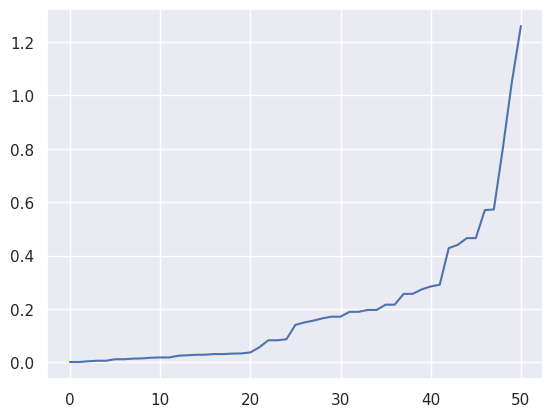

In [ ]:
#@title Elbow criterion for eps

i=0
print("Original shape:", scaled_data.shape)
scaled_data = scaled_data[:, i:i+128]
print("New shape:", scaled_data.shape)
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_data)
distances, indices = nbrs.kneighbors(scaled_data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
#plt.xlim(40, 60)
#plt.ylim(0, 200)
